In [22]:
# !pip uninstall gensim -y
# !pip uninstall numpy -y
# !pip uninstall scipy -y

# !pip install gensim

# after installing restart the kernel

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gensim
from gensim.models import Word2Vec, FastText
import nltk
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')

In [24]:
import os
print(os.getcwd())

/kaggle/working


In [25]:
os.listdir("/kaggle/working")
os.listdir("/kaggle/input/banfakenews-2-0")

['stopwords-bn.txt', 'BanFakeNews-2.0_All60K.csv']

In [26]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
# Stopwords Managing
SW_file = open("/kaggle/input/banfakenews-2-0/stopwords-bn.txt", "r", encoding='utf-8')
SW_BN = SW_file.read()
#print(content)
SW_BN = SW_BN.split()
SW_file.close()
SW_BN[0:10]

['অতএব',
 'অথচ',
 'অথবা',
 'অনুযায়ী',
 'অনেক',
 'অনেকে',
 'অনেকেই',
 'অন্তত',
 'অন্য',
 'অবধি']

In [28]:
#1. Data Preprocessing
class BanglaTextPreprocessor:
    """Class for preprocessing Bangla text data"""

    def __init__(self):
        # Bangla punctuation and special characters
        self.bangla_punctuation = '।,;:!?()[]{}"\''

    def clean_text(self, text):
        """Clean and preprocess Bangla text"""
        if pd.isna(text):
            return ""

        text = str(text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text)

        # Remove English characters (optional - keep if mixed content)
        # text = re.sub(r'[a-zA-Z]', '', text)

        # Remove special characters except Bangla punctuation
        text = re.sub(r'[^\u0980-\u09FF\s\w]', ' ', text)

        # Remove extra spaces
        text = text.strip()

        return text

    def remove_stopwords(self, text):
        """Remove common Bangla stopwords"""

        words = text.split()
        filtered_words = [word for word in words if word not in SW_BN]
        return ' '.join(filtered_words)

In [29]:
df = pd.read_csv("/kaggle/input/banfakenews-2-0/BanFakeNews-2.0_All60K.csv")
#df = df.drop(['SN', 'Dataset'], axis=1)
#df.drop(['Dataset'], axis=1)
print(df.shape)
df_Cont = df[['Content', 'Label']].copy()
print(df_Cont.shape)
df_Cont

(61581, 4)
(61581, 2)


,Content,Label
0,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1
...,...,...
61576,বৃষ্টির দাপটে শুক্রবার খেলা হয়েছে মোটে ২৯ ওভার...,0
61577,পৃথিবীর যে মেয়েটি আকাশরাজের বাড়ি কাজ করে তার ন...,0
61578,বান্দরবা‌নের নাইক্ষ্যংছ‌ড়ি উপজেলায় পু‌লি‌শের স...,0
61579,১-৩ শ্রেনী পর্যন্ত পরীক্ষা বাতিলের কথা শুনে দে...,0


In [30]:
# Load preprocessor
preprocessor = BanglaTextPreprocessor()

# Apply preprocessing
df_Cont['cleaned_text'] = df_Cont['Content'].apply(preprocessor.clean_text)
df_Cont['processed_text'] = df_Cont['cleaned_text'].apply(preprocessor.remove_stopwords)

print(f"Dataset shape: {df_Cont.shape}")
print(f"Label distribution:\n{df_Cont['Label'].value_counts()}")
print(f"\nSample texts:")
for i in range(3):
    print(f"Original: {df_Cont.iloc[i]['Content']}")
    print(f"Processed: {df_Cont.iloc[i]['processed_text']}")
    print(f"Label: {'Fake' if df_Cont.iloc[i]['Label'] == 0 else 'Real'}")
    print("-" * 80)

Dataset shape: (61581, 4)
Label distribution:
Label
1    48678
0    12903
Name: count, dtype: int64

Sample texts:
Original: গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে (বাকৃবি) উপাচার্যের কার্যালয়ে হট্টগোলের ঘটনায় দুইজনকে সাময়িক বরখাস্ত ও ছয় জনকে শোকজ করেছে বিশ্ববিদ্যালয় প্রশাসন। বুধবার বিশ্ববিদ্যালয় বাকৃবি রেজিস্ট্রার সাইফুল ইসলাম স্বাক্ষরিত এক নোটিশে আগামী ৭ দিনের মধ্যে উপযুক্ত উত্তর দেয়ার নির্দেশ দেয়া হয়েছে। এদিকে এ ঘটনায় আন্দোলনের সঙ্গে একাত্বতা প্রকাশ না করায় হামলার শিকার হয়ে কারিগরি কর্মচারী পরিষদের সভাপতি ও সাধারণ সম্পাদক হাসপাতালে ভর্তি হয়েছেন। সাময়িক বরখাস্তরা হলেন- শিক্ষা বিষয়ক শাখার কর্মচারী ও ৩য় শ্রেণির সাধারণ সম্পাদক মো. মোশারফ হোসেন ও কর্মকর্তা পরিষদের যুগ্ম সম্পাদক জিয়াউর রহমান টিটু। এছাড়া বিশ্ববিদ্যালয় সম্প্রসারণ কেন্দ্রের সহকারী পরিচালক মোহাম্মদ আবুল বাসার আমজাদ, ডেপুটি লাইব্রেরিয়ান মো.খাইরুল আলম নান্নু, মো.আবদুল বাতেন, ক্রীড়া প্রশিক্ষণ বিভাগের মোহাম্মদ মোস্তাইন কবীর সোহেল, সংস্থাপন শাখার সহকারী রেজিস্ট্রার মোহাম্মদ আশিকুল আলম বাচ্চু ও খামার ব্যবস্থাপনা শাখার অ্যাডি

In [31]:
df_Cont

,Content,Label,cleaned_text,processed_text
0,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...
1,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় শ্রমিক পা...
2,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি হওয়া...
3,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...
4,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে বেসরকারি টেল...
...,...,...,...,...
61576,বৃষ্টির দাপটে শুক্রবার খেলা হয়েছে মোটে ২৯ ওভার...,0,বৃষ্টির দাপটে শুক্রবার খেলা হয়েছে মোটে ২৯ ওভার...,বৃষ্টির দাপটে শুক্রবার খেলা হয়েছে মোটে ২৯ ওভার...
61577,পৃথিবীর যে মেয়েটি আকাশরাজের বাড়ি কাজ করে তার ন...,0,পৃথিবীর যে মেয়েটি আকাশরাজের বাড়ি কাজ করে তার ন...,পৃথিবীর মেয়েটি আকাশরাজের বাড়ি নাম সরলা মাকে দে...
61578,বান্দরবা‌নের নাইক্ষ্যংছ‌ড়ি উপজেলায় পু‌লি‌শের স...,0,বান্দরবা নের নাইক্ষ্যংছ ড়ি উপজেলায় পু লি শের স...,বান্দরবা নের নাইক্ষ্যংছ ড়ি উপজেলায় পু লি শের ব...
61579,১-৩ শ্রেনী পর্যন্ত পরীক্ষা বাতিলের কথা শুনে দে...,0,১ ৩ শ্রেনী পর্যন্ত পরীক্ষা বাতিলের কথা শুনে দে...,১ ৩ শ্রেনী পরীক্ষা বাতিলের কথা শুনে দেশের স্কু...


In [32]:
# 2. Feature Extraction Methods

class FeatureExtractor:
    """Class for extracting various features from Bangla text"""

    def __init__(self):
        self.tfidf_vectorizer = None
        self.word2vec_model = None
        self.fasttext_model = None
        self.char_vectorizer = None
        self.ngram_vectorizer = None

    def extract_tfidf_features(self, texts, max_features=5000):
        """Extract TF-IDF features"""
        print("Extracting TF-IDF features...")

        if self.tfidf_vectorizer is None:
            self.tfidf_vectorizer = TfidfVectorizer(
                max_features=max_features,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95
            )
            tfidf_features = self.tfidf_vectorizer.fit_transform(texts)
        else:
            tfidf_features = self.tfidf_vectorizer.transform(texts)

        return tfidf_features.toarray()

    def extract_word2vec_features(self, texts, vector_size=100):
        """Extract Word2Vec features"""
        print("Extracting Word2Vec features...")

        # Tokenize texts
        tokenized_texts = [text.split() for text in texts]

        if self.word2vec_model is None:
            self.word2vec_model = Word2Vec(
                sentences=tokenized_texts,
                vector_size=vector_size,
                window=5,
                min_count=1,
                workers=4,
                seed=42
            )

        # Get the actual vector size from the model
        actual_size = self.word2vec_model.vector_size

        # Create document vectors by averaging word vectors
        doc_vectors = []
        for tokens in tokenized_texts:
            vectors = [self.word2vec_model.wv[word] for word in tokens if word in self.word2vec_model.wv]
            if vectors:
                doc_vector = np.mean(vectors, axis=0)
            else:
                doc_vector = np.zeros(actual_size, dtype=np.float32)  # Use actual_size instead of vector_size
            doc_vectors.append(doc_vector)

        return np.array(doc_vectors, dtype=np.float32)


    def extract_fasttext_features(self, texts, vector_size=100):
        """Extract FastText features"""
        print("Extracting FastText features...")

        # Tokenize texts
        tokenized_texts = [text.split() for text in texts]

        if self.fasttext_model is None:
            self.fasttext_model = FastText(
                sentences=tokenized_texts,
                vector_size=vector_size,
                window=5,
                min_count=1,
                workers=4,
                seed=42
            )

        # Get the actual vector size from the model
        actual_size = self.fasttext_model.vector_size

        # Create document vectors
        doc_vectors = []
        for tokens in tokenized_texts:
            vectors = [self.fasttext_model.wv[word] for word in tokens if word in self.fasttext_model.wv]
            if vectors:
                doc_vector = np.mean(vectors, axis=0)
            else:
                doc_vector = np.zeros(actual_size, dtype=np.float32)  # Use actual_size instead of vector_size
            doc_vectors.append(doc_vector)

        return np.array(doc_vectors, dtype=np.float32)

    def extract_ngram_features(self, texts, n=3, max_features=1000):
        """Extract N-gram features"""
        print(f"Extracting {n}-gram features...")

        if self.ngram_vectorizer is None:
            self.ngram_vectorizer = CountVectorizer(
                ngram_range=(n, n),
                max_features=max_features,
                min_df=2
            )
            ngram_features = self.ngram_vectorizer.fit_transform(texts)
        else:
            ngram_features = self.ngram_vectorizer.transform(texts)

        return ngram_features.toarray()

    def extract_char_features(self, texts, max_features=1000):
        """Extract character-level features"""
        print("Extracting character-level features...")

        if self.char_vectorizer is None:
            self.char_vectorizer = TfidfVectorizer(
                analyzer='char',
                ngram_range=(2, 4),
                max_features=max_features,
                min_df=2
            )
            char_features = self.char_vectorizer.fit_transform(texts)
        else:
            char_features = self.char_vectorizer.transform(texts)

        return char_features.toarray()

    # def extract_sentiment_features(self, texts):
    #     """Extract sentiment-based features"""
    #     print("Extracting sentiment features...")

    #     sentiment_features = []
    #     for text in texts:
    #         # Simple sentiment analysis (you can replace with Bangla-specific sentiment analyzer)
    #         try:
    #             # Ensure text is not None or empty
    #             if text and isinstance(text, str):
    #                  blob = TextBlob(text)
    #                  polarity = blob.sentiment.polarity
    #                  subjectivity = blob.sentiment.subjectivity
    #             else:
    #                  polarity = 0.0
    #                  subjectivity = 0.0
    #         except:
    #             polarity = 0.0
    #             subjectivity = 0.0

    #         sentiment_features.append([polarity, subjectivity])

    #     return np.array(sentiment_features)

    def extract_statistical_features(self, texts):
        """Extract statistical text features"""
        print("Extracting statistical features...")

        statistical_features = []
        for text in texts:
             # Ensure text is a string, handle None/NaN
            if pd.isna(text) or not isinstance(text, str):
                text = ""

            # Text length features
            char_count = len(text)
            words = text.split()
            word_count = len(words)
            sentence_count = len(text.split('।')) + len(text.split('.'))

            # Average word length
            avg_word_length = np.mean([len(word) for word in words]) if words else 0

            # Punctuation count
            punctuation_count = sum(1 for char in text if char in '।,;:!?()[]{}"\'-')

            # Uppercase ratio (might not be relevant for Bangla)
            # uppercase_ratio = sum(1 for char in text if char.isupper()) / len(text) if text else 0

            # Digit count
            digit_count = sum(1 for char in text if char.isdigit())

            features = [
                char_count,
                word_count,
                sentence_count,
                avg_word_length,
                punctuation_count,
                digit_count,
                char_count / word_count if word_count > 0 else 0,  # avg chars per word
                punctuation_count / char_count if char_count > 0 else 0  # punctuation ratio
            ]

            statistical_features.append(features)

        return np.array(statistical_features)

In [33]:
# Initialize feature extractor
feature_extractor = FeatureExtractor()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_Cont['processed_text'].values,
    df_Cont['Label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_Cont['Label'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 49264
Testing samples: 12317


In [34]:
# 3. Extract All Features

# Extract features for training data
print("=" * 60)
print("EXTRACTING FEATURES FOR TRAINING DATA")
print("=" * 60)

# 1. TF-IDF features
tfidf_train = feature_extractor.extract_tfidf_features(X_train, max_features=2000)
tfidf_test = feature_extractor.extract_tfidf_features(X_test)

# 2. Word2Vec features
w2v_train = feature_extractor.extract_word2vec_features(X_train, vector_size=50)
w2v_test = feature_extractor.extract_word2vec_features(X_test)

# 3. FastText features
ft_train = feature_extractor.extract_fasttext_features(X_train, vector_size=50)
ft_test = feature_extractor.extract_fasttext_features(X_test)

# 4. N-gram features
ngram_train = feature_extractor.extract_ngram_features(X_train, n=2, max_features=500)
ngram_test = feature_extractor.extract_ngram_features(X_test)

# 5. Character-level features
char_train = feature_extractor.extract_char_features(X_train, max_features=500)
char_test = feature_extractor.extract_char_features(X_test)

# 6. Sentiment features
#sentiment_train = feature_extractor.extract_sentiment_features(X_train)
#sentiment_test = feature_extractor.extract_sentiment_features(X_test)

# 7. Statistical features
stats_train = feature_extractor.extract_statistical_features(X_train)
stats_test = feature_extractor.extract_statistical_features(X_test)

print("\n" + "=" * 60)
print("FEATURE EXTRACTION SUMMARY")
print("=" * 60)
print(f"TF-IDF features shape: {tfidf_train.shape}")
print(f"Word2Vec features shape: {w2v_train.shape}")
print(f"FastText features shape: {ft_train.shape}")
print(f"N-gram features shape: {ngram_train.shape}")
print(f"Character features shape: {char_train.shape}")
#print(f"Sentiment features shape: {sentiment_train.shape}")
print(f"Statistical features shape: {stats_train.shape}")

EXTRACTING FEATURES FOR TRAINING DATA
Extracting TF-IDF features...
Extracting TF-IDF features...
Extracting Word2Vec features...
Extracting Word2Vec features...
Extracting FastText features...
Extracting FastText features...
Extracting 2-gram features...
Extracting 3-gram features...
Extracting character-level features...
Extracting character-level features...
Extracting statistical features...
Extracting statistical features...

FEATURE EXTRACTION SUMMARY
TF-IDF features shape: (49264, 2000)
Word2Vec features shape: (49264, 50)
FastText features shape: (49264, 50)
N-gram features shape: (49264, 500)
Character features shape: (49264, 500)
Statistical features shape: (49264, 8)


In [35]:
# Normalize features
# scaler = StandardScaler()
# sentiment_train_scaled = scaler.fit_transform(sentiment_train)
# sentiment_test_scaled = scaler.transform(sentiment_test)

stats_scaler = StandardScaler()
stats_train_scaled = stats_scaler.fit_transform(stats_train)
stats_test_scaled = stats_scaler.transform(stats_test)

In [36]:
# 4. CNN Model Architecture

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Reshape
from tensorflow.keras.models import Model

class CNNFakeNewsClassifier:
    def __init__(self):
        self.model = None
        self.history = None

    def build_individual_cnn(self, input_shape, name_prefix):
        """Build individual CNN for each feature type"""
        input_layer = Input(shape=input_shape, name=f'{name_prefix}_input')

        # Reshape for Conv1D if needed using Keras layers instead of tf.expand_dims
        if len(input_shape) == 1:
            # For 1D features, reshape to (timesteps, 1)
            reshaped = Reshape((input_shape[0], 1), name=f'{name_prefix}_reshape')(input_layer)
        else:
            reshaped = input_layer

        # Conv1D layers
        conv1 = Conv1D(filters=64,
                      kernel_size=3,
                      activation='relu',
                      name=f'{name_prefix}_conv1')(reshaped)
        pool1 = MaxPooling1D(pool_size=2, name=f'{name_prefix}_pool1')(conv1)

        conv2 = Conv1D(filters=32,
                      kernel_size=3,
                      activation='relu',
                      name=f'{name_prefix}_conv2')(pool1)
        pool2 = GlobalMaxPooling1D(name=f'{name_prefix}_global_pool')(conv2)

        # Dense layers
        dense1 = Dense(64, activation='relu', name=f'{name_prefix}_dense1')(pool2)
        dropout1 = Dropout(0.5, name=f'{name_prefix}_dropout1')(dense1)
        dense2 = Dense(32, activation='relu', name=f'{name_prefix}_dense2')(dropout1)
        dropout2 = Dropout(0.3, name=f'{name_prefix}_dropout2')(dense2)

        return input_layer, dropout2

    def build_model(self, feature_shapes):
        """
        Build CNN model for fake news classification

        Args:
            feature_shapes: dict containing shapes of different features
                          e.g., {'tfidf': (5000,), 'word2vec': (100,), 'fasttext': (100,),
                                'ngram': (1000,), 'char': (1000,)}
        """
        print("Building CNN model...")

        # Define inputs for each feature type
        inputs = {}
        processed_features = []

        # Process each feature type
        for feature_name, shape in feature_shapes.items():
            # Create input layer
            input_layer = Input(shape=shape, name=f'{feature_name}_input')
            inputs[feature_name] = input_layer

            # Reshape for CNN if needed (add channel dimension)
            if len(shape) == 1:
                # For 1D features, reshape to (features, 1) for 1D CNN
                reshaped = layers.Reshape((shape[0], 1))(input_layer)
            else:
                reshaped = input_layer

            # Apply 1D CNN layers
            conv1 = layers.Conv1D(
                filters=64,
                kernel_size=3,
                activation='relu',
                padding='same',
                name=f'{feature_name}_conv1'
            )(reshaped)

            conv2 = layers.Conv1D(
                filters=32,
                kernel_size=3,
                activation='relu',
                padding='same',
                name=f'{feature_name}_conv2'
            )(conv1)

            # Global max pooling to get fixed-size output
            pooled = layers.GlobalMaxPooling1D(name=f'{feature_name}_pool')(conv2)

            # Add dropout for regularization
            dropped = layers.Dropout(0.3, name=f'{feature_name}_dropout')(pooled)

            processed_features.append(dropped)

        # Concatenate all processed features
        if len(processed_features) > 1:
            concatenated = layers.Concatenate(name='feature_concat')(processed_features)
        else:
            concatenated = processed_features[0]

        # Dense layers for classification
        dense1 = layers.Dense(256, activation='relu', name='dense1')(concatenated)
        dense1_dropout = layers.Dropout(0.5, name='dense1_dropout')(dense1)

        dense2 = layers.Dense(128, activation='relu', name='dense2')(dense1_dropout)
        dense2_dropout = layers.Dropout(0.3, name='dense2_dropout')(dense2)

        dense3 = layers.Dense(64, activation='relu', name='dense3')(dense2_dropout)

        # Output layer (binary classification)
        output = layers.Dense(1, activation='sigmoid', name='output')(dense3)

        # Create model
        self.model = Model(inputs=list(inputs.values()), outputs=output, name='CNN_FakeNews_Classifier')

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Model built successfully!")
        return self.model

    def train_model(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=16, verbose=1):
        """Train the model"""
        if self.model is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        # Prepare callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7
            )
        ]

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.history

    def evaluate_model(self, X_test_dict, y_test):
        """Evaluate the model"""
        X_test_list = [X_test_dict[key] for key in X_test_dict.keys()]

        # Get predictions
        y_pred_proba = self.model.predict(X_test_list)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        print("=" * 60)
        print("MODEL EVALUATION RESULTS")
        print("=" * 60)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Fake', 'Real'],
                   yticklabels=['Fake', 'Real'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig("evaluationCM.pdf", dpi=300)
        plt.show()

        return {
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_pred_proba.flatten()
        }

# Example of how to prepare feature_shapes and data

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot training & validation accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Plot training & validation loss
        axes[0, 1].plot(self.history.history['loss'], label='Training Loss')
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Plot precision
        if 'precision' in self.history.history:
            axes[1, 0].plot(self.history.history['precision'], label='Training Precision')
            axes[1, 0].plot(self.history.history['val_precision'], label='Validation Precision')
            axes[1, 0].set_title('Model Precision')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True)

        # Plot recall
        if 'recall' in self.history.history:
            axes[1, 1].plot(self.history.history['recall'], label='Training Recall')
            axes[1, 1].plot(self.history.history['val_recall'], label='Validation Recall')
            axes[1, 1].set_title('Model Recall')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        plt.tight_layout()
        plt.savefig("trainingHist.pdf", dpi=300)
        plt.show()

    # def prepare_features_and_shapes(tfidf_train, w2v_train, ft_train, ngram_train, char_train):
    #     """
    #     Prepare feature shapes dictionary and combined training data
    #     """
    #     feature_shapes = {
    #         'tfidf': tfidf_train.shape[1:],
    #         'word2vec': w2v_train.shape[1:],
    #         'fasttext': ft_train.shape[1:],
    #         'ngram': ngram_train.shape[1:],
    #         'char': char_train.shape[1:]
    #     }

    #     # Combine features into list (order matters - should match inputs order)
    #     X_train_combined = [tfidf_train, w2v_train, ft_train, ngram_train, char_train]

    #     return feature_shapes, X_train_combined

In [37]:
# 5. Model Training and Evaluation

# Prepare feature dictionaries
X_train_features = {
    'tfidf': tfidf_train,
    'word2vec': w2v_train,
    'fasttext': ft_train,
    'ngram': ngram_train,
    'char': char_train,
    #'sentiment': sentiment_train_scaled,
    'stats': stats_train_scaled
}

X_test_features = {
    'tfidf': tfidf_test,
    'word2vec': w2v_test,
    'fasttext': ft_test,
    'ngram': ngram_test,
    'char': char_test,
    #'sentiment': sentiment_test_scaled,
    'stats': stats_test_scaled
}

# Define feature shapes
feature_shapes = {
    'tfidf': (tfidf_train.shape[1],),
    'word2vec': (w2v_train.shape[1],),
    'fasttext': (ft_train.shape[1],),
    'ngram': (ngram_train.shape[1],),
    'char': (char_train.shape[1],),
    #'sentiment': (sentiment_train_scaled.shape[1],),
    'stats': (stats_train_scaled.shape[1],)
}

# Create validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Extract features for validation data
print("Extracting features for validation data...")
tfidf_val = feature_extractor.tfidf_vectorizer.transform(X_val_split).toarray()
w2v_val = feature_extractor.extract_word2vec_features(X_val_split)
ft_val = feature_extractor.extract_fasttext_features(X_val_split)
ngram_val = feature_extractor.ngram_vectorizer.transform(X_val_split).toarray()
char_val = feature_extractor.char_vectorizer.transform(X_val_split).toarray()
#sentiment_val = scaler.transform(feature_extractor.extract_sentiment_features(X_val_split))
stats_val = stats_scaler.transform(feature_extractor.extract_statistical_features(X_val_split))

# Update training features (remove validation samples)
tfidf_train_split = feature_extractor.tfidf_vectorizer.transform(X_train_split).toarray()
w2v_train_split = feature_extractor.extract_word2vec_features(X_train_split)
ft_train_split = feature_extractor.extract_fasttext_features(X_train_split)
ngram_train_split = feature_extractor.ngram_vectorizer.transform(X_train_split).toarray()
char_train_split = feature_extractor.char_vectorizer.transform(X_train_split).toarray()
#sentiment_train_split = scaler.transform(feature_extractor.extract_sentiment_features(X_train_split))
stats_train_split = stats_scaler.transform(feature_extractor.extract_statistical_features(X_train_split))

X_train_final = {
    'tfidf': tfidf_train_split,
    'word2vec': w2v_train_split,
    'fasttext': ft_train_split,
    'ngram': ngram_train_split,
    'char': char_train_split,
    'stats': stats_train_split
}

X_val_final = {
    'tfidf': tfidf_val,
    'word2vec': w2v_val,
    'fasttext': ft_val,
    'ngram': ngram_val,
    'char': char_val,
    'stats': stats_val
}

Extracting features for validation data...
Extracting Word2Vec features...
Extracting FastText features...
Extracting statistical features...
Extracting Word2Vec features...
Extracting FastText features...
Extracting statistical features...


In [38]:
print(len(X_train_final))
print(len(y_train_split))

6
39411


**Combining All the Features**

Building CNN model...


I0000 00:00:1749813612.109417      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model built successfully!


Model: "CNN_FakeNews_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tfidf_input (InputLayer)  │ (None, 2000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word2vec_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fasttext_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ngram_input (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_input (InputLayer)   │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stats_input (InputLayer)  │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 2000, 1)        │              0 │ tfidf_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 50, 1)          │              0 │ word2vec_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 50, 1)          │              0 │ fasttext_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 500, 1)         │              0 │ ngram_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 500, 1)         │              0 │ char_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 8, 1)           │              0 │ stats_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tfidf_conv1 (Conv1D)      │ (None, 2000, 64)       │            256 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word2vec_conv1 (Conv1D)   │ (None, 50, 64)         │            256 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fasttext_conv1 (Conv1D)   │ (None, 50, 64)         │            256 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ngram_conv1 (Conv1D)      │ (None, 500, 64)        │            256 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_conv1 (Conv1D)       │ (None, 500, 64)        │            256 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stats_conv1 (Conv1D)      │ (None, 8, 64)          │            256 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tfidf_conv2 (Conv1D) 

 Total params: 129,217 (504.75 KB)

 Trainable params: 129,217 (504.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1749813623.495299     237 service.cc:148] XLA service 0x78eafc01ed40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749813623.497980     237 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749813624.407532     237 cuda_dnn.cc:529] Loaded cuDNN version 90300


   8/2464 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7372 - loss: 0.6283 - precision: 0.7954 - recall: 0.8939   

I0000 00:00:1749813631.179793     237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2464/2464 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.7904 - loss: 0.4845 - precision: 0.7922 - recall: 0.9955 - val_accuracy: 0.8613 - val_loss: 0.3718 - val_precision: 0.8894 - val_recall: 0.9416 - learning_rate: 1.0000e-04
Epoch 2/50
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8534 - loss: 0.3936 - precision: 0.8659 - recall: 0.9633 - val_accuracy: 0.8781 - val_loss: 0.3374 - val_precision: 0.8998 - val_recall: 0.9519 - learning_rate: 1.0000e-04
Epoch 3/50
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8705 - loss: 0.3557 - precision: 0.8785 - recall: 0.9698 - val_accuracy: 0.8827 - val_loss: 0.3303 - val_precision: 0.9047 - val_recall: 0.9519 - learning_rate: 1.0000e-04
Epoch 4/50
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8754 - loss: 0.3398 - precision: 0.8824 - recall: 0.9716 - val_accuracy: 0.8884 - val_loss: 0.3173 - val_precision: 0.9043 - val_recall: 0.9605 - learning_rate: 1.0000e-04
Epoch 5/50
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3

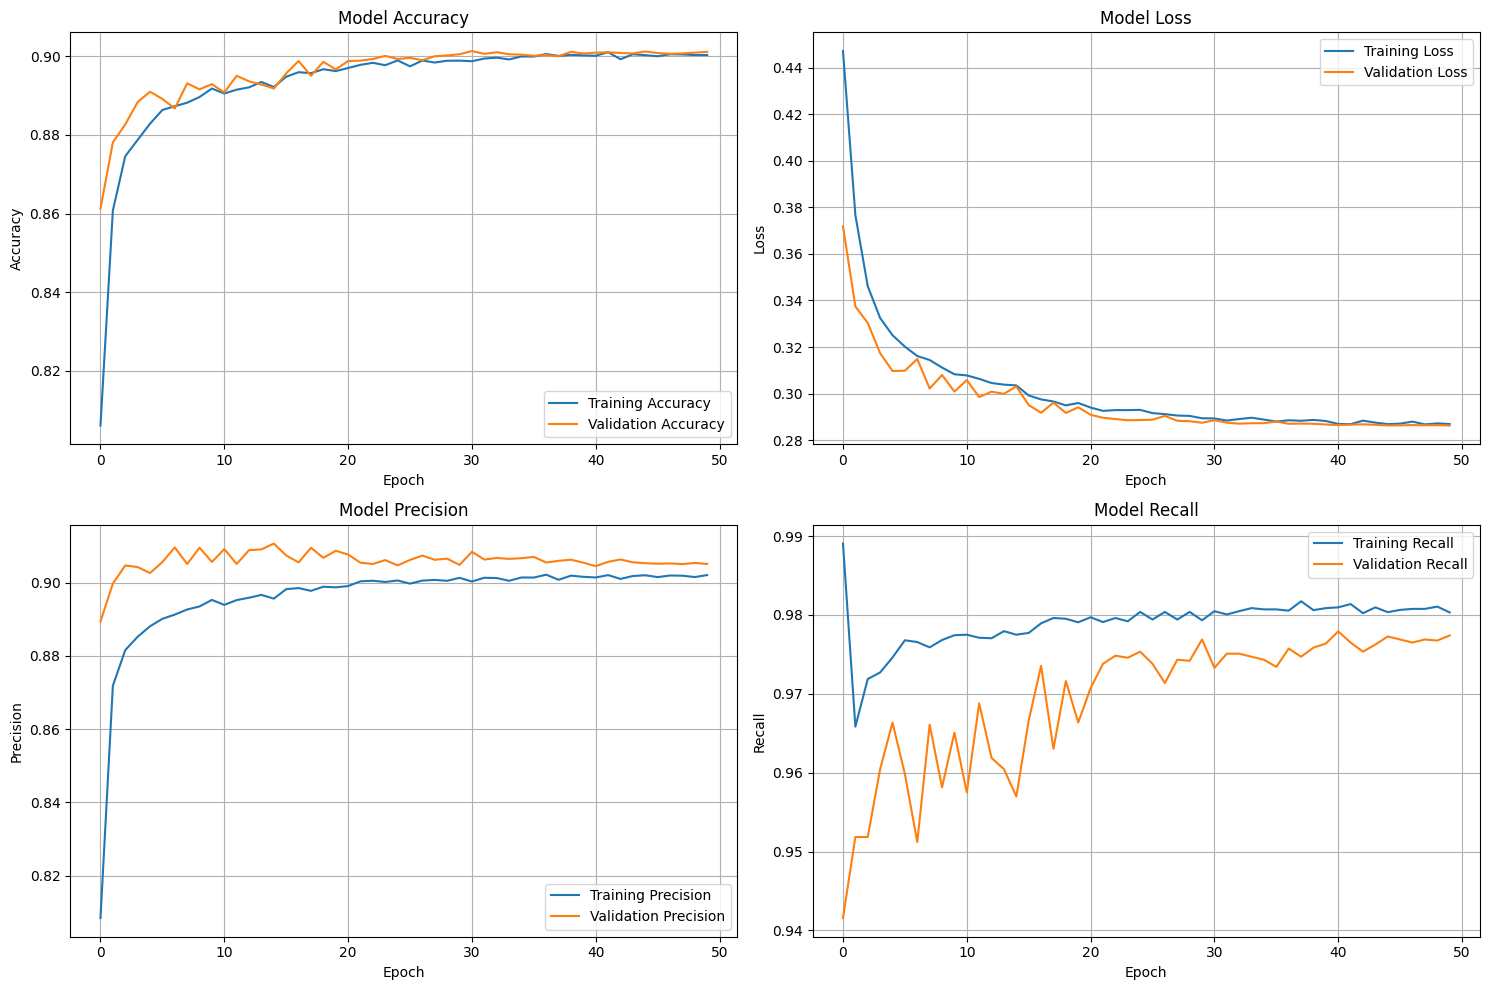

In [ ]:
# First, prepare eature shapes and data
feature_shapes = {
    'tfidf': tfidf_train.shape[1:],      # e.g., (5000,)
    'word2vec': w2v_train.shape[1:],     # e.g., (100,)
    'fasttext': ft_train.shape[1:],      # e.g., (100,)
    'ngram': ngram_train.shape[1:],      # e.g., (1000,)
    'char': char_train.shape[1:],         # e.g., (1000,)
    'stats': stats_train_scaled.shape[1:]
}

# Combine training features into a list
X_train_final = [tfidf_train_split, w2v_train_split, ft_train_split, ngram_train_split, char_train_split, stats_train_split]

# Combine validation features into a list
X_val_final = [tfidf_val, w2v_val, ft_val, ngram_val, char_val, stats_val]


# build and train the model
classifier = CNNFakeNewsClassifier()
model = classifier.build_model(feature_shapes)
model.summary()

# Train
history = classifier.train_model(
    X_train_final,
    y_train_split,
    X_val_final,
    y_val_split,
    epochs=50,
    batch_size=16,
    verbose=1
)

classifier.plot_training_history()

In [40]:
print(X_test_features.keys())
# X_test_features.pop('sentiment', None)
# X_test_features.pop('stats', None)
# print(X_test_features.keys())

dict_keys(['tfidf', 'word2vec', 'fasttext', 'ngram', 'char', 'stats'])


In [41]:
len(X_train_final[0])

39411

EVALUATING MODEL ON TEST DATA
385/385 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MODEL EVALUATION RESULTS
Accuracy: 0.9016

Classification Report:
              precision    recall  f1-score   support

        Fake       0.89      0.61      0.72      2581
        Real       0.90      0.98      0.94      9736

    accuracy                           0.90     12317
   macro avg       0.90      0.79      0.83     12317
weighted avg       0.90      0.90      0.89     12317



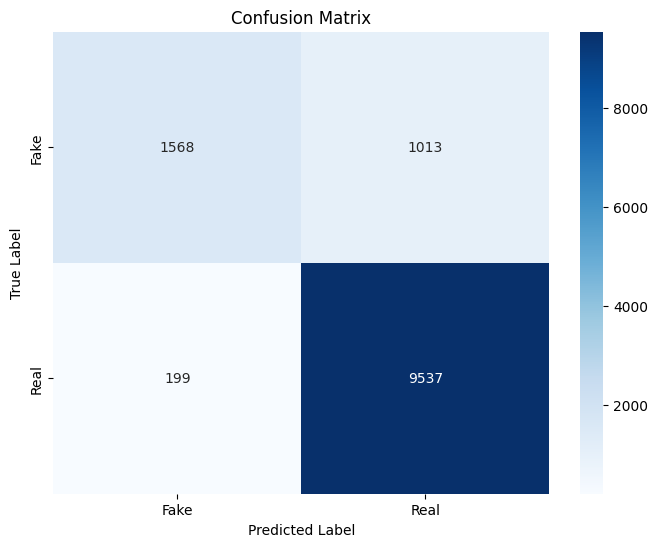


FEATURE IMPORTANCE ANALYSIS
Baseline accuracy (all features): 0.9016

Individual feature performance:
tfidf
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
tfidf       : 0.7905
word2vec
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
word2vec    : 0.8902
fasttext
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
fasttext    : 0.8966
ngram
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ngram       : 0.7905
char
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
char        : 0.8384
stats
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
stats       : 0.8165


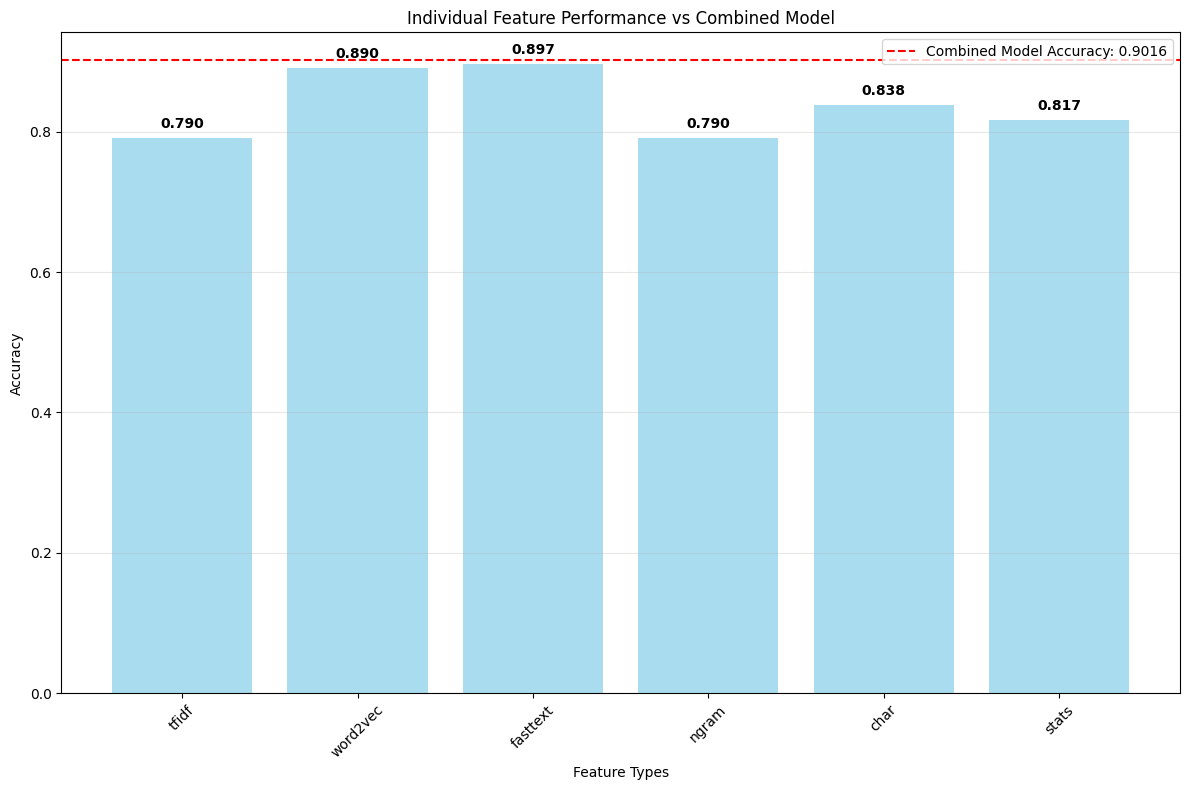

In [42]:
# 6. Model Evaluation and Results

# Evaluate model on test data
print("=" * 60)
print("EVALUATING MODEL ON TEST DATA")
print("=" * 60)

results = classifier.evaluate_model(X_test_features, y_test)

# Feature importance analysis (using a simple approach)
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)


def analyze_feature_importance(model, X_test_dict, y_test, feature_names):
    """Analyze feature importance by testing individual features"""
    baseline_accuracy = results['accuracy']

    print(f"Baseline accuracy (all features): {baseline_accuracy:.4f}")


    print("\nIndividual feature performance:")

    individual_results = {}

    f_i = 0

    for feature_name in feature_names:
        if feature_name == 'sentiment':
            f_i += 1
            continue
        # Create single feature input
        single_feature_dict = {feature_name: X_test_dict[feature_name]}

        # Build and train a simple model for this feature
        temp_classifier = CNNFakeNewsClassifier()
        temp_feature_shapes = {feature_name: X_test_dict[feature_name].shape[1:]}
        temp_model = temp_classifier.build_individual_cnn(X_test_dict[feature_name].shape[1:], feature_name)

        # Create simple model for single feature
        input_layer, feature_output = temp_model
        output = Dense(1, activation='sigmoid')(feature_output)
        single_model = Model(inputs=input_layer, outputs=output)
        single_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Quick training (reduced epochs for analysis)
        print(feature_name)
        single_X_train = X_train_final[f_i]
        f_i += 1
        single_model.fit(single_X_train, y_train_split, epochs=10, verbose=0, batch_size=16)

        # Evaluate
        single_pred = single_model.predict(X_test_dict[feature_name])
        single_pred_binary = (single_pred > 0.5).astype(int).flatten()
        single_accuracy = accuracy_score(y_test, single_pred_binary)

        individual_results[feature_name] = single_accuracy
        print(f"{feature_name:12}: {single_accuracy:.4f}")

    return individual_results

feature_names = list(X_test_features.keys())
individual_accuracies = analyze_feature_importance(
    classifier.model, X_test_features, y_test, feature_names
)

# Visualize feature importance
plt.figure(figsize=(12, 8))
feature_names_display = list(individual_accuracies.keys())
accuracies = list(individual_accuracies.values())

bars = plt.bar(feature_names_display, accuracies, color='skyblue', alpha=0.7)
plt.axhline(y=results['accuracy'], color='red', linestyle='--',
           label=f'Combined Model Accuracy: {results["accuracy"]:.4f}')
plt.xlabel('Feature Types')
plt.ylabel('Accuracy')
plt.title('Individual Feature Performance vs Combined Model')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("FeatureImportance.pdf", dpi=300)
plt.show()

In [44]:
# 8. Model Interpretation and Examples

# Sample predictions with explanations
print("=" * 60)
print("SAMPLE PREDICTIONS WITH ANALYSIS")
print("=" * 60)

def analyze_prediction(text_idx, texts, true_labels, predictions, probabilities):
    """Analyze individual prediction"""
    text = texts[text_idx]
    true_label = "Fake" if true_labels[text_idx] == 0 else "Real"
    pred_label = "Fake" if predictions[text_idx] == 0 else "Real"
    confidence = probabilities[text_idx]

    print(f"Sample {text_idx + 1}:")
    print(f"Text: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Correct: {'✓' if true_label == pred_label else '✗'}")

    # Feature analysis for this sample
    sample_features = {
        'TF-IDF': np.mean(tfidf_test[text_idx]),
        'Word2Vec': np.mean(w2v_test[text_idx]),
        'FastText': np.mean(ft_test[text_idx]),
        'N-gram': np.mean(ngram_test[text_idx]),
        'Character': np.mean(char_test[text_idx]),
        #'Sentiment': np.mean(sentiment_test_scaled[text_idx]),
        'Statistical': np.mean(stats_test_scaled[text_idx])
    }

    print("Feature Summary:")
    for feature_name, feature_value in sample_features.items():
        print(f"  {feature_name}: {feature_value:.4f}")

    print("-" * 80)

# Analyze a few sample predictions
sample_indices = [0, 1000, 2000, 5, 8600, 10003]  # Select some samples
for idx in sample_indices:
    if idx < len(X_test):
        analyze_prediction(idx, X_test, y_test, results['predictions'], results['probabilities'])


SAMPLE PREDICTIONS WITH ANALYSIS
Sample 1:
Text: ভাবছিলাম একটা কেক পাই যেটা সমকামী বিয়ে ভুল সহনশীল প্রশ্ন অনুসরণ বামের বিস্ময়কর ভণ্ডামিকে প্রদর্শন বলুন শ্রেষ্ঠত্ব ভুল বহুগামিতা ভুল ঘৃণাত্মক হিসেবে বিবেচিত মত সমকামী বিবাহ ভুল সারা বিশ্ব বর্ণবাদ ঘৃণাকে চিৎকার উঠে নীচে নেমে রাজনৈতিক সঠিক এক প্রথায় পরিণত যুক্তি প্রদান করুক বাক স্বাধীনতাকে দমন গে পন্থী বেকারিদের লক্ষ্যবস্তুতে পরিণত সমকামী একটিভিস্টরা খ্রিস্টান বেকারিদের লক্ষ্যবস্তুতে পরিণত সমকামী বিবাহকে সমর্থন করুন একজন খ্রিষ্টান বেকারীর বিরুদ্ধে মামলা স্লোগানকে পুরুষ সমকামীদের দাবীর সমর্থনে এক অনুষ্ঠানে কেকের রাখতে অস্বীকার খ্রিস্টান বেকারিগুলো সমকামী বিয়ের কেক তৈরি বিরুদ্ধে মামলা দায়ের বাম ডান মাঝখানে জরিমানা মৃত্যুর হুমকি পায় ব্যবসা হারায় পরীক্ষা সন্দেহাতীতভাবে প্রমান পুরুষ সমকামীরা শুধুমাত্র যৌন অভিমুখীতা চর্চা স্বাধীনতাই নি বাক স্বাধীনতা দমন মামলাটিকে তিনটি ভিডিও ক্লিপ দিয়েছি তৃতীয় ভিডিওটিতে আয়ারল্যান্ডের সমকামী কর্মীরা খ্রিস্টান বেকারিকে জোর সমকামী বিয়ের স্লোগান কেক বানাতে রাজ্যটিকে প্রত্যাখ্যান ব্যবসায় বিশাল ক্ষতি যোগ খ্

In [46]:
os.getcwd()

'/kaggle/working'

In [47]:
# 10. Saving and Loading the Model

# Save the trained model and preprocessors
import joblib
import os

def save_model_and_components(classifier, feature_extractor, scaler, stats_scaler, save_dir=os.getcwd()):
    """Save all model components"""

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save the main model
    classifier.model.save(os.path.join(save_dir, 'cnn_model.h5'))
    #classifier.model.save(os.path.join(save_dir, 'cnn_model.h5'))

    # Save feature extractors and scalers
    joblib.dump(feature_extractor, os.path.join(save_dir, 'feature_extractor.pkl'))
    joblib.dump(scaler, os.path.join(save_dir, 'sentiment_scaler.pkl'))
    joblib.dump(stats_scaler, os.path.join(save_dir, 'stats_scaler.pkl'))

    # Save feature shapes for model reconstruction
    joblib.dump(feature_shapes, os.path.join(save_dir, 'feature_shapes.pkl'))

    print(f"Model and components saved to: {save_dir}")

def load_model_and_components(save_dir=os.getcwd()):
    """Load all model components"""
    from tensorflow.keras.models import load_model

    # Load the main model
    loaded_model = load_model(os.path.join(save_dir, 'cnn_model.h5'))

    # Load feature extractors and scalers
    loaded_feature_extractor = joblib.load(os.path.join(save_dir, 'feature_extractor.pkl'))
    loaded_scaler = joblib.load(os.path.join(save_dir, 'sentiment_scaler.pkl'))
    loaded_stats_scaler = joblib.load(os.path.join(save_dir, 'stats_scaler.pkl'))
    loaded_feature_shapes = joblib.load(os.path.join(save_dir, 'feature_shapes.pkl'))

    print(f"Model and components loaded from: {save_dir}")

    return loaded_model, loaded_feature_extractor, loaded_scaler, loaded_stats_scaler, loaded_feature_shapes

def predict_new_text(text, model, feature_extractor, stats_scaler):
#def predict_new_text(text, model, feature_extractor, sentiment_scaler, stats_scaler):
    """Predict on new text using the saved model"""

    # Preprocess text
    preprocessor = BanglaTextPreprocessor()
    cleaned_text = preprocessor.clean_text(text)
    processed_text = preprocessor.remove_stopwords(cleaned_text)

    # Extract all features
    tfidf_feat = feature_extractor.tfidf_vectorizer.transform([processed_text]).toarray()
    w2v_feat = feature_extractor.extract_word2vec_features([processed_text])
    ft_feat = feature_extractor.extract_fasttext_features([processed_text])
    ngram_feat = feature_extractor.ngram_vectorizer.transform([processed_text]).toarray()
    char_feat = feature_extractor.char_vectorizer.transform([processed_text]).toarray()

    #sentiment_feat = feature_extractor.extract_sentiment_features([processed_text])
    #sentiment_feat_scaled = sentiment_scaler.transform(sentiment_feat)

    stats_feat = feature_extractor.extract_statistical_features([processed_text])
    stats_feat_scaled = stats_scaler.transform(stats_feat)

    # Prepare features for prediction
    features_list = [tfidf_feat, w2v_feat, ft_feat, ngram_feat, char_feat,
                    stats_feat_scaled]
    #features_list = [tfidf_feat, w2v_feat, ft_feat, ngram_feat, char_feat,
    #                sentiment_feat_scaled, stats_feat_scaled]

    # Make prediction
    prediction_prob = model.predict(features_list)[0][0]
    prediction_class = 1 if prediction_prob > 0.5 else 0

    return {
        'text': text,
        'processed_text': processed_text,
        'prediction': 'Fake' if prediction_class == 0 else 'Real',
        'probability': prediction_prob,
        'confidence': max(prediction_prob, 1 - prediction_prob)
    }

# Save the model (uncomment to save)
# save_model_and_components(classifier, feature_extractor, scaler, stats_scaler)

# Example of predicting on new text
sample_news = [
    "প্রধানমন্ত্রী আজ নতুন অর্থনৈতিক নীতি ঘোষণা করেছেন।",
    "এই খবরটি সম্পূর্ণ মিথ্যা এবং ভুল তথ্য।",
    "ঈদের ছুটিতে স্ত্রী-সন্তানের সঙ্গে সোনারগাঁয় শ্বশুরবাড়িতে বেড়াতে যাওয়ার কথা ছিল যুবদল কর্মী মামুন ভূঁইয়ার (৩৫)। কিন্তু ব্যবসায়িক ব্যস্ততার কারণে যাওয়া হয়নি। মঙ্গলবার দুপুরে স্ত্রী ও দুই সন্তানকে শ্বশুরবাড়ির উদ্দেশে গাড়িতে তুলে দিয়ে তাঁদের থেকে বিদায় নেন। বিদায়ের সময় ছোট্ট দুই সন্তানের কপালে চুমু খেয়েছিলেন। নিজেও কপাল বাড়িয়ে নিয়েছিলেন সন্তানের চুমু। এর কিছুক্ষণ পরেই গুলিবিদ্ধ হয়ে মামুন মারা যান।"
]

print("\n" + "=" * 60)
print("SAMPLE PREDICTIONS ON NEW TEXT")
print("=" * 60)

for i, news_text in enumerate(sample_news, 1):
    result = predict_new_text(news_text, classifier.model, feature_extractor, stats_scaler)
    print(f"\nSample {i}:")
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Probability: {result['probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("-" * 40)

print("\n" + "=" * 60)
print("NOTEBOOK EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("\nSummary of Implementation:")
print("✓ Multiple feature extraction methods implemented")
print("✓ CNN model architecture designed and trained")
print("✓ Comprehensive evaluation and analysis performed")
print("✓ Model saving and loading functionality included")
print("✓ Ready for production use with new text prediction")


SAMPLE PREDICTIONS ON NEW TEXT
Extracting Word2Vec features...
Extracting FastText features...
Extracting statistical features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step

Sample 1:
Text: প্রধানমন্ত্রী আজ নতুন অর্থনৈতিক নীতি ঘোষণা করেছেন।
Prediction: Real
Probability: 0.9008
Confidence: 0.9008
----------------------------------------
Extracting Word2Vec features...
Extracting FastText features...
Extracting statistical features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Sample 2:
Text: এই খবরটি সম্পূর্ণ মিথ্যা এবং ভুল তথ্য।
Prediction: Real
Probability: 0.9438
Confidence: 0.9438
----------------------------------------
Extracting Word2Vec features...
Extracting FastText features...
Extracting statistical features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Sample 3:
Text: ঈদের ছুটিতে স্ত্রী-সন্তানের সঙ্গে সোনারগাঁয় শ্বশুরবাড়িতে বেড়াতে যাওয়ার কথা ছিল যুবদল কর্মী মামুন ভূঁইয়ার (৩৫)। কিন্তু ব্যবসায়িক ব্যস্ততার কারণে যাওয়া হয়নি। মঙ্গলবার দুপুরে স্ত্রী ও দুই সন্তানকে শ্বশুরবাড়ির উদ্দেশে গাড়িতে 

# **Feature Selection**

In [49]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, mutual_info_classif,
    RFE, RFECV, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ============================================================
# METHOD 1: STATISTICAL FEATURE SELECTION
# ============================================================

def statistical_feature_selection(features_dict, y_train, method='f_classif', k=4):
    """
    Select features based on statistical tests

    Parameters:
    - features_dict: {'tfidf': X_tfidf, 'word2vec': X_w2v, ...}
    - y_train: target labels
    - method: 'f_classif', 'chi2', 'mutual_info'
    - k: number of features to select
    """

    # Combine all features
    feature_names = list(features_dict.keys())
    X_combined = np.concatenate([features_dict[name] for name in feature_names], axis=1)

    # Select statistical test
    if method == 'f_classif':
        selector = SelectKBest(score_func=f_classif, k=k)
    elif method == 'chi2':
        # Chi2 requires non-negative features
        X_combined = np.abs(X_combined)
        selector = SelectKBest(score_func=chi2, k=k)
    elif method == 'mutual_info':
        selector = SelectKBest(score_func=mutual_info_classif, k=k)

    # Fit selector
    X_selected = selector.fit_transform(X_combined, y_train)

    # Get feature scores
    scores = selector.scores_
    selected_indices = selector.get_support(indices=True)

    # Map back to original features
    feature_boundaries = np.cumsum([features_dict[name].shape[1] for name in feature_names])
    feature_boundaries = np.insert(feature_boundaries, 0, 0)

    selected_features = []
    for idx in selected_indices:
        for i, boundary in enumerate(feature_boundaries[1:]):
            if idx < boundary:
                selected_features.append(feature_names[i])
                break

    # Count selections per feature type
    feature_importance = {name: selected_features.count(name) for name in feature_names}

    print(f"\n{method.upper()} Feature Selection Results:")
    print("="*50)
    for feature, count in feature_importance.items():
        print(f"{feature}: {count} features selected")

    return selected_features, feature_importance, X_selected

# ============================================================
# METHOD 2: ENSEMBLE-BASED FEATURE IMPORTANCE
# ============================================================

def ensemble_feature_importance(features_dict, y_train, estimator_type='random_forest'):
    """
    Use ensemble methods to rank feature importance
    """

    feature_names = list(features_dict.keys())
    X_combined = np.concatenate([features_dict[name] for name in feature_names], axis=1)

    # Create feature name mapping
    feature_name_mapping = []
    for name in feature_names:
        n_features = features_dict[name].shape[1]
        feature_name_mapping.extend([name] * n_features)

    # Select estimator
    if estimator_type == 'random_forest':
        estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    elif estimator_type == 'extra_trees':
        estimator = ExtraTreesClassifier(n_estimators=100, random_state=42)

    # Fit and get importances
    estimator.fit(X_combined, y_train)
    importances = estimator.feature_importances_

    # Aggregate importance by feature type
    feature_importance = {}
    for i, feature_type in enumerate(feature_name_mapping):
        if feature_type not in feature_importance:
            feature_importance[feature_type] = []
        feature_importance[feature_type].append(importances[i])

    # Calculate mean importance for each feature type
    mean_importance = {k: np.mean(v) for k, v in feature_importance.items()}

    print(f"\n{estimator_type.upper()} Feature Importance:")
    print("="*50)
    sorted_importance = sorted(mean_importance.items(), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")

    return mean_importance, importances

# ============================================================
# METHOD 3: RECURSIVE FEATURE ELIMINATION (RFE)
# ============================================================

def recursive_feature_elimination(features_dict, y_train, n_features_to_select=4):
    """
    Use RFE to select best feature combinations
    """

    feature_names = list(features_dict.keys())
    X_combined = np.concatenate([features_dict[name] for name in feature_names], axis=1)

    # Create feature boundaries for mapping
    feature_boundaries = np.cumsum([features_dict[name].shape[1] for name in feature_names])
    feature_boundaries = np.insert(feature_boundaries, 0, 0)

    # Use Logistic Regression as base estimator
    estimator = LogisticRegression(random_state=42, max_iter=1000)

    # Apply RFE
    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X_combined, y_train)

    # Get selected feature indices
    selected_indices = rfe.get_support(indices=True)

    # Map back to feature types
    selected_features = []
    for idx in selected_indices:
        for i, boundary in enumerate(feature_boundaries[1:]):
            if idx < boundary:
                selected_features.append(feature_names[i])
                break

    # Count selections per feature type
    feature_count = {name: selected_features.count(name) for name in feature_names}

    print("\nRecursive Feature Elimination Results:")
    print("="*50)
    for feature, count in feature_count.items():
        print(f"{feature}: {count} features selected")

    return selected_features, feature_count, X_selected

# ============================================================
# METHOD 4: CORRELATION-BASED FEATURE SELECTION
# ============================================================

def correlation_based_selection(features_dict, y_train, threshold=0.1):
    """
    Select features based on correlation with target and remove redundant features
    """

    feature_names = list(features_dict.keys())

    # Calculate correlation with target for each feature type
    target_correlations = {}

    for name, X_feature in features_dict.items():
        # Calculate mean correlation with target
        correlations = []
        for i in range(X_feature.shape[1]):
            try:
                corr, _ = pearsonr(X_feature[:, i], y_train)
                correlations.append(abs(corr))
            except:
                correlations.append(0)

        target_correlations[name] = np.mean(correlations)

    print("\nCorrelation with Target:")
    print("="*50)
    sorted_corr = sorted(target_correlations.items(), key=lambda x: x[1], reverse=True)
    for feature, corr in sorted_corr:
        print(f"{feature}: {corr:.4f}")

    # Select features above threshold
    selected_features = [name for name, corr in target_correlations.items() if corr > threshold]

    return selected_features, target_correlations

# ============================================================
# METHOD 5: FORWARD/BACKWARD SELECTION
# ============================================================

def forward_feature_selection(features_dict_train, features_dict_val, y_train, y_val, max_features=6):
    """
    Forward selection based on validation performance
    
    Parameters:
    - features_dict_train: Training features {'tfidf': X_tfidf_train, ...}
    - features_dict_val: Validation features {'tfidf': X_tfidf_val, ...}
    - y_train: Training labels
    - y_val: Validation labels
    - max_features: Maximum number of features to select
    """

    from sklearn.linear_model import LogisticRegression

    feature_names = list(features_dict_train.keys())
    selected_features = []
    remaining_features = feature_names.copy()
    best_scores = []

    print("\nForward Feature Selection:")
    print("="*50)

    for step in range(min(max_features, len(feature_names))):
        best_score = 0
        best_feature = None

        for feature in remaining_features:
            # Test current selection + this feature
            test_features = selected_features + [feature]

            # Combine selected features
            X_train_combined = np.concatenate([features_dict_train[f] for f in test_features], axis=1)
            X_val_combined = np.concatenate([features_dict_val[f] for f in test_features], axis=1)

            # Train and evaluate
            clf = LogisticRegression(random_state=42, max_iter=1000)
            clf.fit(X_train_combined, y_train)

            # Use F1-score for fake news (minority class)
            y_pred = clf.predict(X_val_combined)
            score = f1_score(y_val, y_pred, pos_label=0)  # Assuming 0 = fake news

            if score > best_score:
                best_score = score
                best_feature = feature

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_scores.append(best_score)
            print(f"Step {step+1}: Added '{best_feature}' (F1: {best_score:.4f})")
        else:
            break

    return selected_features, best_scores

# ============================================================
# METHOD 6: COMPREHENSIVE FEATURE COMBINATION TESTING
# ============================================================

def comprehensive_feature_testing(features_dict_train, features_dict_val, y_train, y_val, min_features=2):
    """
    Test all possible combinations of features
    
    Parameters:
    - features_dict_train: Training features {'tfidf': X_tfidf_train, ...}
    - features_dict_val: Validation features {'tfidf': X_tfidf_val, ...}
    - y_train: Training labels
    - y_val: Validation labels
    - min_features: Minimum number of features in combination
    """

    from itertools import combinations
    from sklearn.linear_model import LogisticRegression

    feature_names = list(features_dict_train.keys())
    results = []

    print("\nComprehensive Feature Combination Testing:")
    print("="*50)

    # Test all combinations from min_features to all features
    for r in range(min_features, len(feature_names) + 1):
        for combo in combinations(feature_names, r):
            # Combine features
            X_train_combined = np.concatenate([features_dict_train[f] for f in combo], axis=1)
            X_val_combined = np.concatenate([features_dict_val[f] for f in combo], axis=1)

            # Train and evaluate
            clf = LogisticRegression(random_state=42, max_iter=1000)
            clf.fit(X_train_combined, y_train)

            y_pred = clf.predict(X_val_combined)

            # Calculate metrics
            accuracy = accuracy_score(y_val, y_pred)
            f1_fake = f1_score(y_val, y_pred, pos_label=0)  # Fake news F1
            f1_real = f1_score(y_val, y_pred, pos_label=1)  # Real news F1
            f1_macro = f1_score(y_val, y_pred, average='macro')

            results.append({
                'features': combo,
                'n_features': len(combo),
                'accuracy': accuracy,
                'f1_fake': f1_fake,
                'f1_real': f1_real,
                'f1_macro': f1_macro
            })

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Sort by F1 score for fake news (most important for your case)
    results_df = results_df.sort_values('f1_fake', ascending=False)

    print("\nTop 10 Feature Combinations (by Fake News F1-score):")
    print("-" * 80)
    for i, row in results_df.head(10).iterrows():
        features_str = ', '.join(row['features'])
        print(f"{features_str:40} | F1_fake: {row['f1_fake']:.3f} | F1_macro: {row['f1_macro']:.3f} | Acc: {row['accuracy']:.3f}")

    return results_df

# ============================================================
# METHOD 7: FEATURE IMPORTANCE VISUALIZATION
# ============================================================

def visualize_feature_importance(feature_importance_dict, title="Feature Importance"):
    """
    Visualize feature importance scores
    """

    features = list(feature_importance_dict.keys())
    scores = list(feature_importance_dict.values())

    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(features, scores)

    # Color bars based on importance
    colors = plt.cm.viridis(np.linspace(0, 1, len(scores)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.xlabel('Importance Score')
    plt.title(title)
    plt.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (feature, score) in enumerate(zip(features, scores)):
        plt.text(score + max(scores) * 0.01, i, f'{score:.3f}',
                va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# ============================================================
# COMPLETE PIPELINE FOR YOUR CASE
# ============================================================

def complete_feature_selection_pipeline(features_dict_train, features_dict_val, y_train, y_val):
    """
    Run complete feature selection pipeline with multiple methods
    
    Parameters:
    - features_dict_train: Training features {'tfidf': X_tfidf_train, ...}
    - features_dict_val: Validation features {'tfidf': X_tfidf_val, ...}
    - y_train: Training labels
    - y_val: Validation labels
    """

    print("FAKE NEWS FEATURE SELECTION PIPELINE")
    print("="*60)

    results = {}

    # Method 1: Statistical Selection
    print("\n1. STATISTICAL FEATURE SELECTION")
    selected_stat, importance_stat, _ = statistical_feature_selection(
        features_dict_train, y_train, method='f_classif', k=4
    )
    results['statistical'] = importance_stat

    # Method 2: Ensemble Importance
    print("\n2. ENSEMBLE-BASED IMPORTANCE")
    importance_rf, _ = ensemble_feature_importance(
        features_dict_train, y_train, estimator_type='random_forest'
    )
    results['random_forest'] = importance_rf

    # Method 3: Correlation-based
    print("\n3. CORRELATION-BASED SELECTION")
    selected_corr, corr_scores = correlation_based_selection(
        features_dict_train, y_train, threshold=0.05
    )
    results['correlation'] = corr_scores

    # Method 4: Forward Selection
    print("\n4. FORWARD SELECTION")
    selected_forward, forward_scores = forward_feature_selection(
        features_dict_train, features_dict_val, y_train, y_val, max_features=4
    )

    # Method 5: Comprehensive Testing (top combinations only)
    print("\n5. COMPREHENSIVE COMBINATION TESTING")
    results_df = comprehensive_feature_testing(
        features_dict_train, features_dict_val, y_train, y_val, min_features=2
    )

    # Summary and Recommendations
    print("\n" + "="*60)
    print("SUMMARY AND RECOMMENDATIONS")
    print("="*60)

    # Get best combination for fake news detection
    best_combo = results_df.iloc[0]
    print(f"\nBest combination for Fake News F1-score:")
    print(f"Features: {', '.join(best_combo['features'])}")
    print(f"Fake News F1: {best_combo['f1_fake']:.3f}")
    print(f"Overall Accuracy: {best_combo['accuracy']:.3f}")

    # Feature frequency across methods
    print(f"\nFeature Selection Frequency:")
    all_features = list(features_dict_train.keys())
    frequency = {}

    for feature in all_features:
        count = 0
        # Count in statistical selection
        count += importance_stat.get(feature, 0) > 0
        # Count in correlation (if selected)
        count += feature in selected_corr
        # Count in forward selection
        count += feature in selected_forward
        # Count in top 3 combinations
        top_combos = results_df.head(3)['features'].tolist()
        count += sum(1 for combo in top_combos if feature in combo)

        frequency[feature] = count

    print("-" * 40)
    sorted_freq = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
    for feature, freq in sorted_freq:
        print(f"{feature:12}: Selected {freq}/6 times")

    return results_df, results

In [50]:
# Combine your training features into a list
#X_train_final = [tfidf_train_split, w2v_train_split, ft_train_split, ngram_train_split, char_train_split, stats_train_split]

# Combine your validation features into a list
#X_val_final = [tfidf_val, w2v_val, ft_val, ngram_val, char_val, stats_val]

In [ ]:
# ============================================================
# CORRECTED USAGE EXAMPLE
# ============================================================

# Create separate feature dictionaries for training and validation
features_dict_train = {
    'tfidf': tfidf_train_split,      # TF-IDF features (training)
    'word2vec': w2v_train_split,     # Word2Vec embeddings (training)
    'fasttext': ft_train_split,      # FastText embeddings (training)
    'ngram': ngram_train_split,      # N-gram features (training)
    'char': char_train_split,        # Character-level features (training)
    'stats': stats_train_split       # Statistical features (training)
}

features_dict_val = {
    'tfidf': tfidf_val,        # TF-IDF features (validation)
    'word2vec': w2v_val,       # Word2Vec embeddings (validation)
    'fasttext': ft_val,        # FastText embeddings (validation)
    'ngram': ngram_val,        # N-gram features (validation)
    'char': char_val,          # Character-level features (validation)
    'stats': stats_val         # Statistical features (validation)
}

# Verify dimensions match
print("Training set dimensions:")
for name, features in features_dict_train.items():
    print(f"{name}: {features.shape}")

print("\nValidation set dimensions:")
for name, features in features_dict_val.items():
    print(f"{name}: {features.shape}")

print(f"\nTarget dimensions:")
print(f"y_train_split: {y_train_split.shape}")
print(f"y_val_split: {y_val_split.shape}")

# Run complete pipeline with corrected parameters
results_df, results = complete_feature_selection_pipeline(
    features_dict_train, features_dict_val, y_train_split, y_val_split
)

Training set dimensions:
tfidf: (39411, 2000)
word2vec: (39411, 50)
fasttext: (39411, 50)
ngram: (39411, 500)
char: (39411, 500)
stats: (39411, 8)

Validation set dimensions:
tfidf: (9853, 2000)
word2vec: (9853, 50)
fasttext: (9853, 50)
ngram: (9853, 500)
char: (9853, 500)
stats: (9853, 8)

Target dimensions:
y_train_split: (39411,)
y_val_split: (9853,)
FAKE NEWS FEATURE SELECTION PIPELINE

1. STATISTICAL FEATURE SELECTION

F_CLASSIF Feature Selection Results:
tfidf: 0 features selected
word2vec: 2 features selected
fasttext: 1 features selected
ngram: 0 features selected
char: 1 features selected
stats: 0 features selected

2. ENSEMBLE-BASED IMPORTANCE

RANDOM_FOREST Feature Importance:
word2vec: 0.0027
fasttext: 0.0025
stats: 0.0010
char: 0.0008
tfidf: 0.0001
ngram: 0.0001

3. CORRELATION-BASED SELECTION

Correlation with Target:
fasttext: 0.1401
word2vec: 0.1296
char: 0.0526
ngram: 0.0304
tfidf: 0.0277
stats: nan

4. FORWARD SELECTION

Forward Feature Selection:
Step 1: Added 'tfidf